In [2]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
importlib.reload(sys.modules['models.ICA_EM'])
from sklearn.metrics import mean_squared_error as mse


In [6]:
n = 10000
J = 6
I = 5

In [4]:
def norm_funtion(A):
    # [0,0], [1,1] must be one
    A_0 = A[:, 0]/A[0,0]
    return A_0

In [4]:
B = 50
scale_grid = np.linspace(1/np.sqrt(2), 3, 5)
treatments_true = np.zeros((len(scale_grid), B))
treatments_pred_perm = np.zeros((len(scale_grid), B))
treatments_pred_first_col = np.zeros((len(scale_grid), B))
ll_score = np.zeros((len(scale_grid), B))
mse_score = np.zeros((len(scale_grid), B))
fscore = np.zeros((len(scale_grid), B))

In [31]:
for i in tqdm.tqdm(range(len(scale_grid))):
    data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : scale_grid[i]})   
    for j in range(B):
        data.generate_data(n, I, J, random_state=j)
        est = CausalVarEM(update_sigma=False, true_A= data.mixing_matrix_observed, random_seed = j, tol=1e-4, max_iter = 100)
        est.fit(data.data_observed, J, progress_bar=False)
        treatments_true[i, j] = data.treatment_effect
        best_perm, score = f_score(data.mixing_matrix_observed, est.A)
        sorted_A = est.A[:, best_perm]
        treatments_pred_perm[i, j] = norm_funtion(sorted_A)[1]
        treatments_pred_first_col[i, j] = norm_funtion(est.A)[1]
        ll_score[i, j] = likelihood_score(data.signals, est.Signals, true_paras={"mean": 0, "scale": 1/np.sqrt(2)})
        mse_score[i, j] = mean_squared_error(data.signals, est.Signals)
        fscore[i, j] = score




100%|██████████| 5/5 [1:36:00<00:00, 1152.15s/it]


In [32]:
# save the results
for i in range(len(scale_grid)):
    df = pd.DataFrame(
        {
            "treatments_true": treatments_true[i],
            "treatments_pred_perm": treatments_pred_perm[i],
       "treatments_pred_first_col": treatments_pred_first_col[i],
            "ll_score": ll_score[i],
            "mse_score": mse_score[i],
            "fscore": fscore[i],
        }
    )
    #df.to_csv(f"results/different_scales/CausalVarEM_{scale_grid[i]}.csv", index=False)

In [5]:
# load the results 
for i in range(len(scale_grid)):
    df = pd.read_csv(f"results/different_scales/CausalVarEM_{scale_grid[i]}.csv")
    treatments_true[i] = df["treatments_true"].values
    treatments_pred_perm[i] = df["treatments_pred_perm"].values
    treatments_pred_first_col[i] = df["treatments_pred_first_col"].values
    ll_score[i] = df["ll_score"].values
    mse_score[i] = df["mse_score"].values
    fscore[i] = df["fscore"].values

<Axes: >

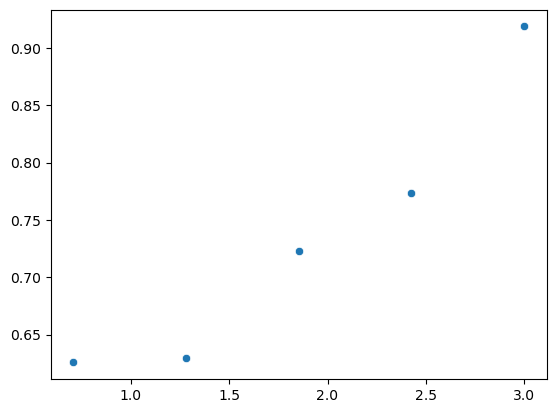

In [7]:
treatment_diff = (treatments_true - treatments_pred_perm)
treatment_mse = np.mean(np.abs(treatment_diff), axis=1)
sns.scatterplot(x=scale_grid, y=treatment_mse)

<Axes: >

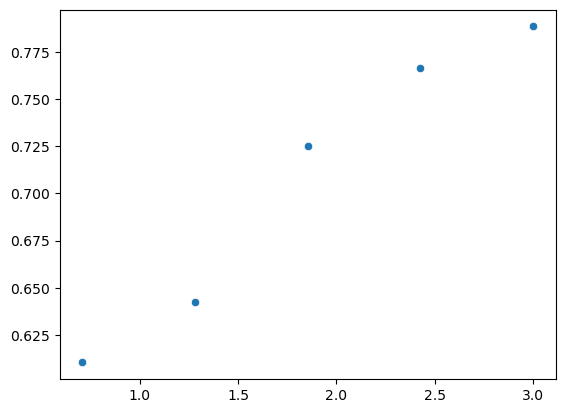

In [8]:
treatment_diff = (treatments_true - treatments_pred_first_col)
treatment_mse = np.mean(np.abs(treatment_diff), axis=1)
sns.scatterplot(x=scale_grid, y=treatment_mse)

<Axes: >

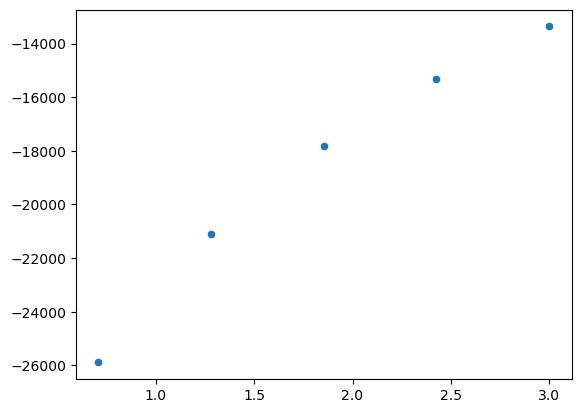

In [9]:
ll_score_mean = np.mean(ll_score, axis=1)
sns.scatterplot(x=scale_grid, y=ll_score_mean)

<Axes: >

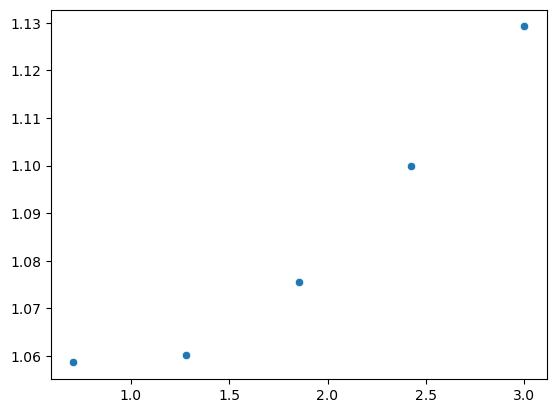

In [10]:
mse_score_mean = np.mean(mse_score, axis=1)
sns.scatterplot(x=scale_grid, y=mse_score_mean)

<Axes: >

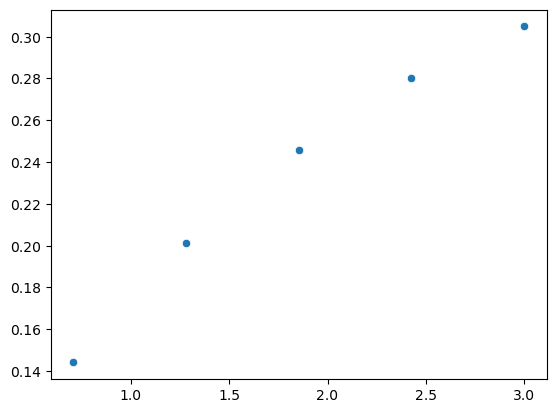

In [11]:
fscore_mean = np.mean(fscore, axis=1)
sns.scatterplot(x=scale_grid, y=fscore_mean)

Text(0.5, 1.0, 'F Score')

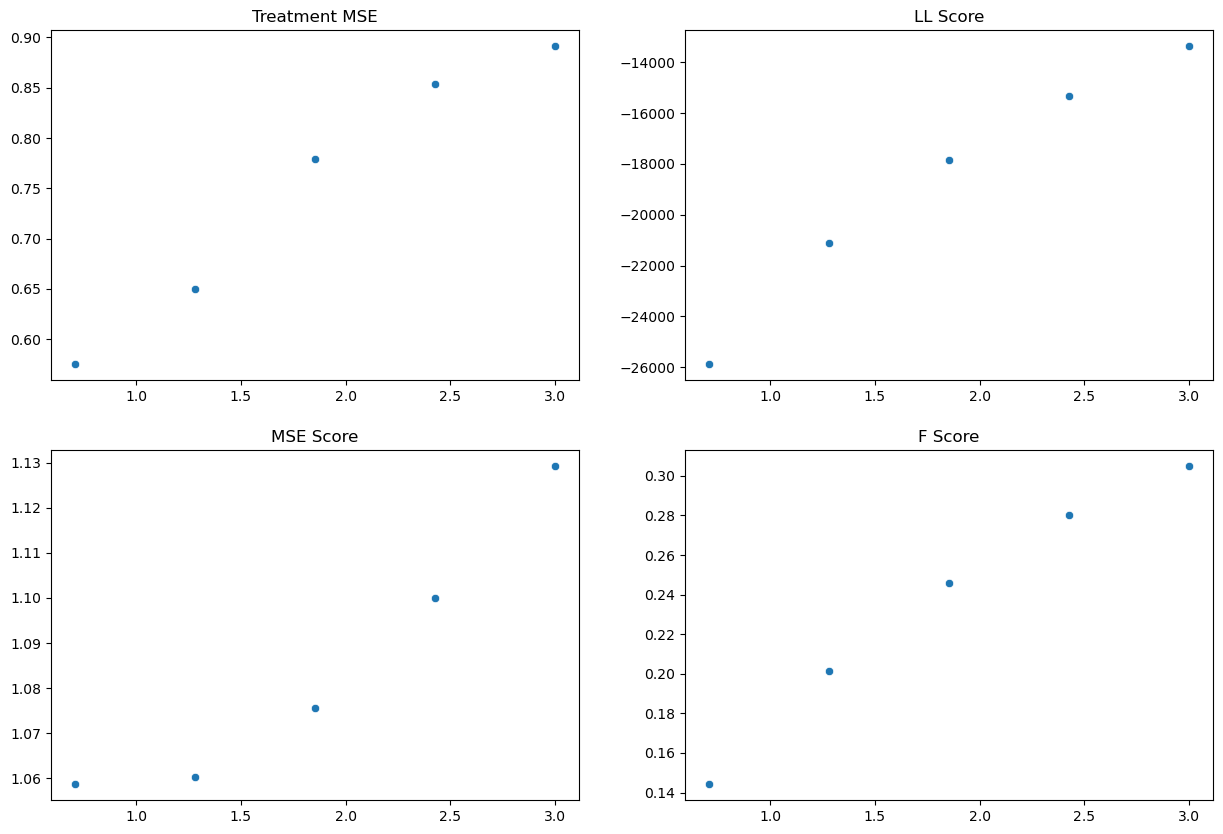

In [12]:
# plot all in one
                            
treatment_diff = (treatments_true - treatments_pred_first_col)
treatment_mse = np.sqrt(np.mean((treatment_diff)**2, axis= 1))
ll_score_mean = np.mean(ll_score, axis=1)

fig, ax = plt.subplots(2, 2, figsize=(15
                                , 10))

sns.scatterplot(x=scale_grid, y=treatment_mse, ax=ax[0, 0])
ax[0, 0].set_title("Treatment MSE")
sns.scatterplot(x=scale_grid, y=ll_score_mean, ax=ax[0, 1])
ax[0, 1].set_title("LL Score")
sns.scatterplot(x=scale_grid, y=mse_score_mean, ax=ax[1, 0])
ax[1, 0].set_title("MSE Score")
sns.scatterplot(x=scale_grid, y=fscore_mean, ax=ax[1, 1])
ax[1, 1].set_title("F Score")

## plot true teatment vs predictied for different scale parameters

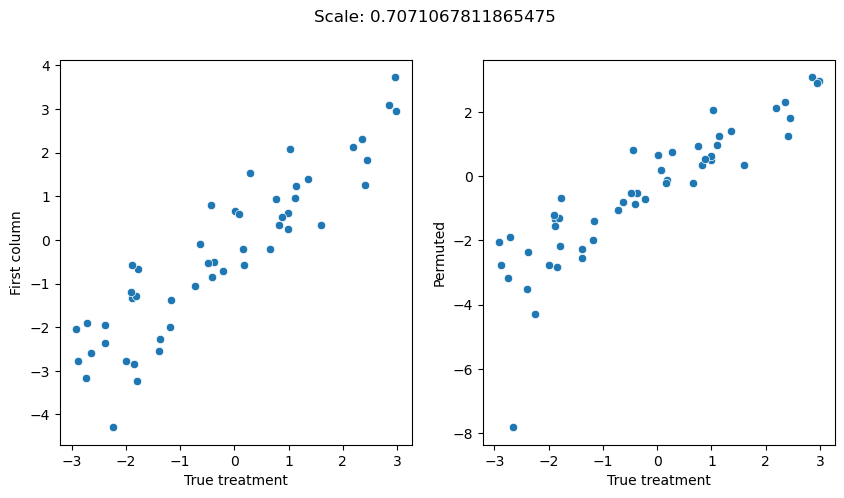

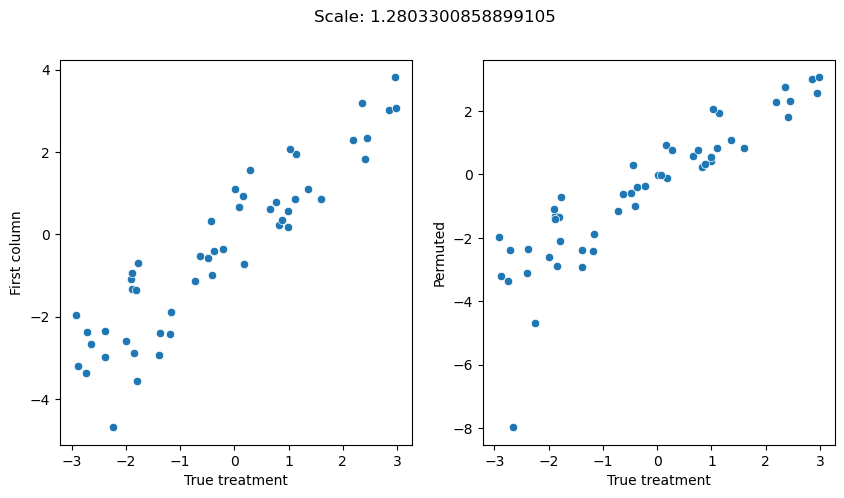

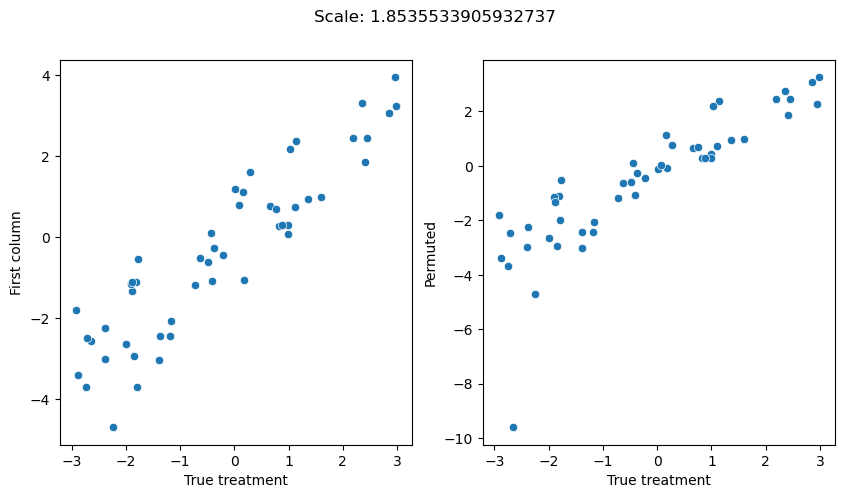

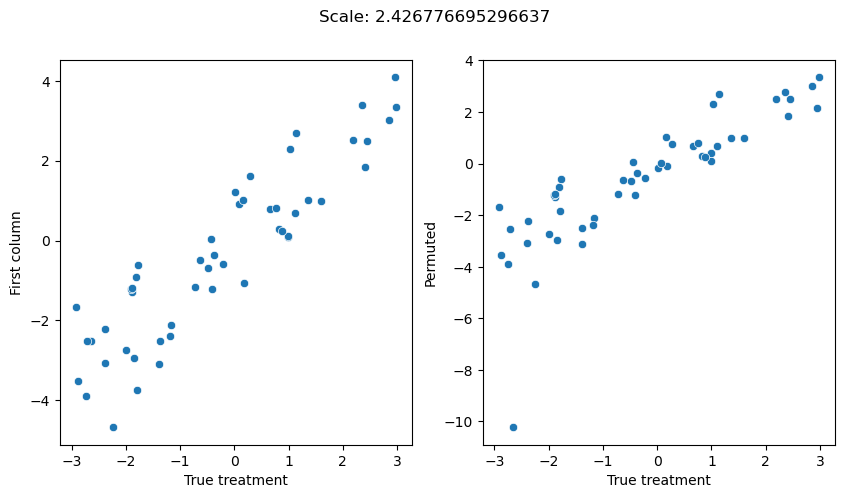

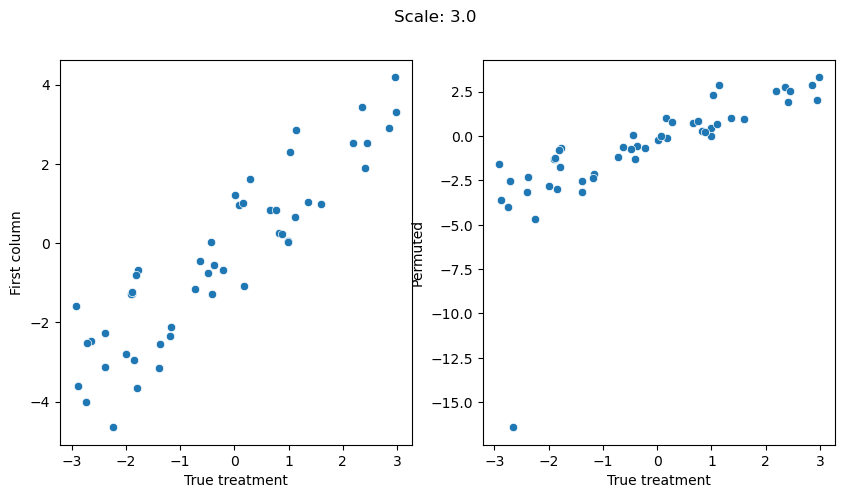

In [13]:
for i in range(len(scale_grid)):
    data = pd.read_csv(f"results/different_scales/CausalVarEM_{scale_grid[i]}.csv")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_first_col"], ax=ax[0])
    ax[0].set_ylabel("First column")
    ax[0].set_xlabel("True treatment")
    fig.suptitle(f"Scale: {scale_grid[i]}")
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_perm"], ax=ax[1])
    ax[1].set_ylabel("Permuted")
    ax[1].set_xlabel("True treatment")
    plt.show()



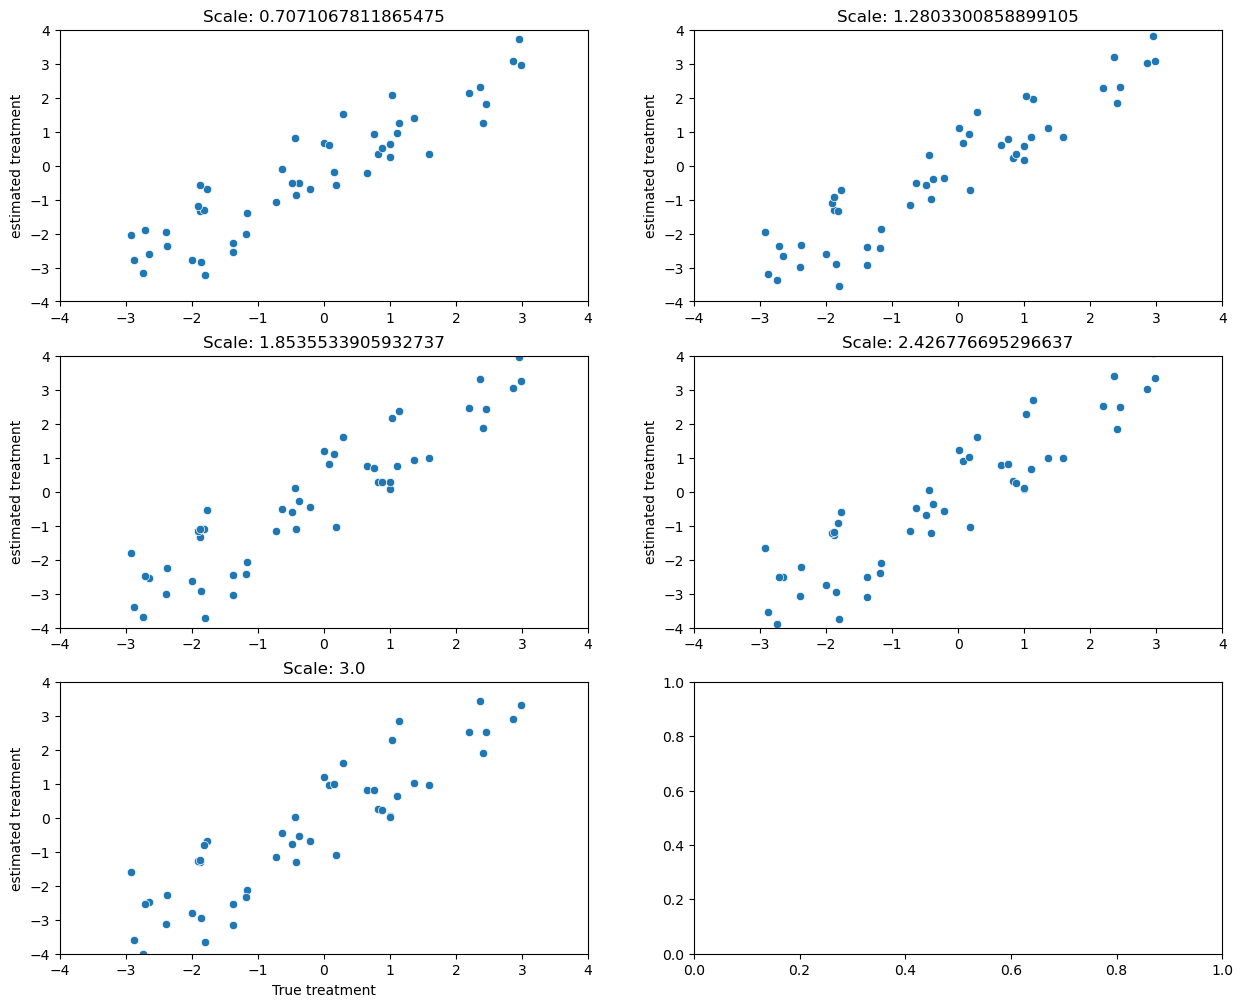

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15,12 ))
axes = axes.flatten()

for i in range(len(scale_grid)):
    # Load the data
    data = pd.read_csv(f"results/different_scales/CausalVarEM_{scale_grid[i]}.csv")

    # Plot on the respective subplot
    sns.scatterplot(x=data["treatments_true"], y=data["treatments_pred_first_col"], ax=axes[i])
    axes[i].set_title(f"Scale: {scale_grid[i]}")
    if i == len(scale_grid) - 1: 
        axes[i].set_xlabel("True treatment")
    else:
        axes[i].set_xlabel("")
    axes[i].set_ylabel("estimated treatment")
    axes[i].set_ylim(-4,4)
    axes[i].set_xlim(-4,4)


## source estimation


In [5]:
# plot signals righltly ordered
data = dgp(prior={"loc" : 0, "scale" : 3}, noise_dict=  {"loc" : 0, "scale" : 0})
data.generate_data(n=n, J=J, I=I, random_state=1)
VarEM_est= CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=0)
VarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1})
best_perm, score = f_score(data.mixing_matrix_observed, VarEM_est.A)


NameError: name 'n' is not defined

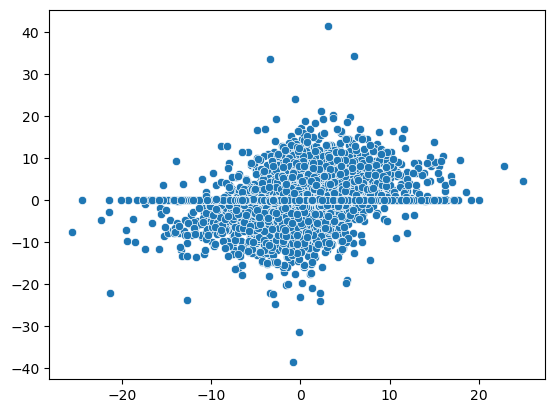

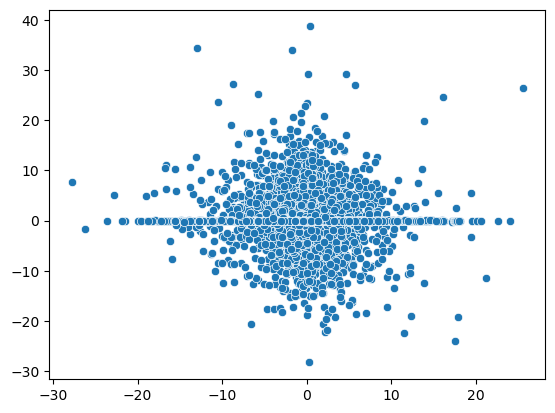

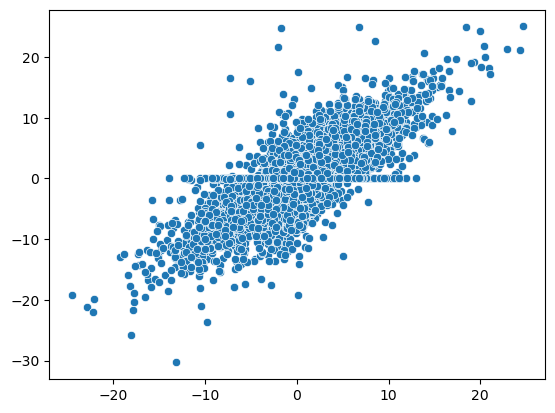

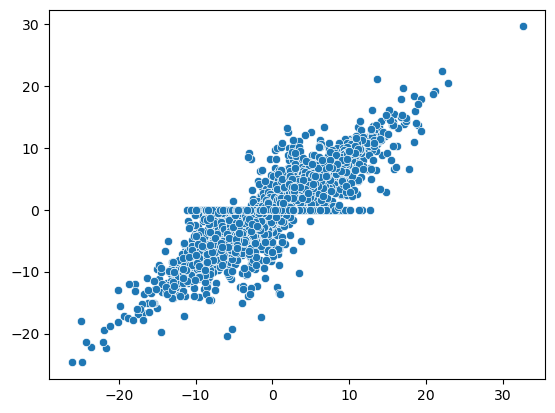

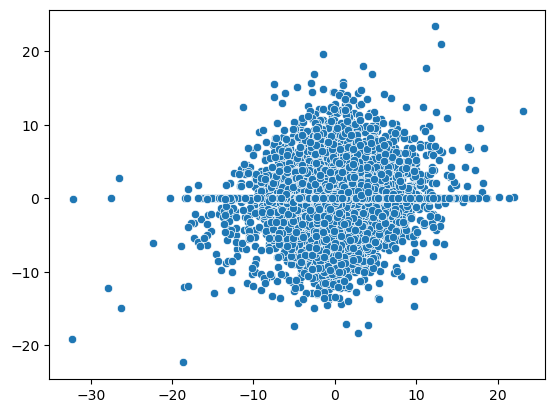

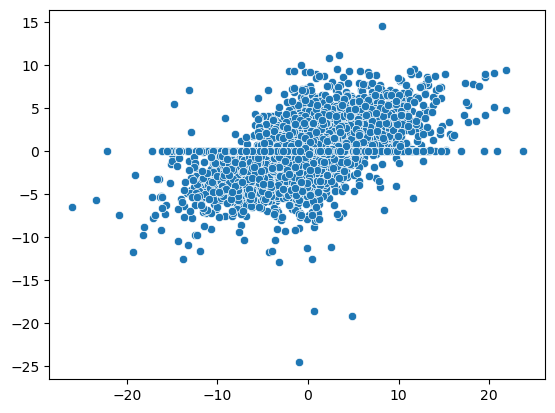

In [15]:
for i in range(J):
    plt.figure()
    sns.scatterplot(x=data.signals[:,i], y=VarEM_est.Signals[:, best_perm[i]])
    plt.plot()

